# Imports

In [10]:
import random
import sys

import importlib
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, metrics

import data_visualisation as dv
import data_augmentation as da
import models.resnet as resnet

# Load the Data

In [11]:
# load data
thismodule = sys.modules[__name__]

with np.load('data/PTB_XL_HB_1s_window.npz', allow_pickle=True) as data:
    for k in data.keys():
        if 'text' in k:
            setattr(thismodule, k, data[k])
        else:
            setattr(thismodule, k, data[k].astype(float))

# Auto-encoder Model

In [3]:
# define an lstm autoencoder model
# Define the LSTM-based autoencoder model
class LSTMAutoencoder(tf.keras.Model):
    def __init__(self, latent_dim):
        super(LSTMAutoencoder, self).__init__()
        self.encoder = layers.LSTM(latent_dim, activation='relu', return_sequences=False, input_shape=(100, 12))
        self.repeat_vector = layers.RepeatVector(100)
        self.decoder = layers.LSTM(12, activation='relu', return_sequences=True)

    def call(self, inputs):
        encoded = self.encoder(inputs)
        repeated = self.repeat_vector(encoded)
        decoded = self.decoder(repeated)
        return decoded

In [3]:
def build_model(input_shape, latent_dim=64):
    model = LSTMAutoencoder(latent_dim)
    input = keras.Input(shape=input_shape)
    output = model(input)
    model = keras.Model(inputs=input, outputs=output)
    model.compile(optimizer='adam', loss='mse')
    model.summary()
    return model

In [3]:

model = build_model(X_train.shape[1:], latent_dim=128)

NameError: name 'build_model' is not defined

In [15]:
def mask_ecg(ecg, mask_ratio=0.1):
    block_size = 20
    
    for lead in range(ecg.shape[1]):
        for i in range(0, ecg.shape[0], block_size):
            if random.random() < mask_ratio:
                ecg[i:i+block_size, lead] = 0
    return ecg

def mask_lead(ecg, mask_ratio=0.1):

    for lead in range(ecg.shape[1]):
        if random.random() < mask_ratio:
            ecg[:, lead] = 0
    return ecg

In [7]:
def mask_ecg(ecg, mask_ratio=0.1, block_size=20):
    ecg_shape = tf.shape(ecg)
    num_blocks = ecg_shape[0] // block_size
    
    mask = tf.random.uniform([num_blocks, ecg_shape[1]], minval=0, maxval=1) < mask_ratio
    mask = tf.reshape(tf.tile(mask[:, None, :], [1, block_size, 1]), ecg_shape)
    
    return tf.where(mask, tf.zeros_like(ecg), ecg)

def mask_lead(ecg, mask_ratio=0.1):
    ecg_shape = tf.shape(ecg)
    
    mask = tf.random.uniform([ecg_shape[1]], minval=0, maxval=1) < mask_ratio
    mask = tf.tile(mask[None, :], [ecg_shape[0], 1])
    
    return tf.where(mask, tf.zeros_like(ecg), ecg)

In [6]:
def augment_ecg_signal(signal):
    drifted_signal, _ = da.add_random_baseline_drift(signal, strength_range=(1.5,2.5), drift_wavelength_range=(300,500))
    noised_drifted_signal = da.add_random_noise(drifted_signal, (0, 0.2))
    res = mask_lead(noised_drifted_signal, mask_ratio=0.2)
    return res

In [5]:
def train_autoencoder(model, data, epochs=50, batch_size=32):
    optimizer = tf.keras.optimizers.Adam()
    loss_fn = tf.keras.losses.MeanSquaredError()
    
    dataset = tf.data.Dataset.from_tensor_slices(X_train)
    dataset = dataset.shuffle(buffer_size=1024).batch(batch_size)
    
    for epoch in range(epochs):
        print(f'\nEpoch {epoch+1}/{epochs}')
        steps = len(X_train) // batch_size
        for step, batch in enumerate(dataset):
            # augmented_batch = tf.map_fn(augment_ecg_signal, batch)

            with tf.GradientTape() as tape:
                reconstructed = model(batch, training=True)
                loss = loss_fn(batch, reconstructed)
            
            grads = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))
            
            print(f"\rEpoch {epoch+1}/{epochs}, Step {step}/{steps}, Loss: {loss.numpy():.4f}", end='')
        model.save(f'model-weights/autoencoder_{epoch+1}.h5')
        
        # print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.numpy()}')

In [8]:
# train
train_autoencoder(model, X_train, epochs=5, batch_size=32)

Epoch 1/5


2024-05-26 17:41:27.412887: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-05-26 17:41:27.835492: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x308be070 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-05-26 17:41:27.835533: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Ti, Compute Capability 8.6
2024-05-26 17:41:27.839364: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-05-26 17:41:27.915934: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Epoch 1/5, Step 7179/7179, Loss: 0.0412Epoch 2/5
Epoch 2/5, Step 7179/7179, Loss: 0.0305Epoch 3/5
Epoch 3/5, Step 7179/7179, Loss: 0.0386Epoch 4/5
Epoch 4/5, Step 7179/7179, Loss: 0.0373Epoch 5/5
Epoch 5/5, Step 7179/7179, Loss: 0.032844384

In [9]:
modelk = keras.models.load_model('model-weights/autoencoder_1.h5')

In [6]:
def make_model(input_shape, latent_dim=64):
    inputs = keras.Input(shape=input_shape)
    x = layers.LSTM(64, activation='relu', return_sequences=False, name='encoder')(inputs)
    x = layers.RepeatVector(100, name='repeat')(x)
    x = layers.LSTM(12, activation='relu', return_sequences=True, name='decoder')(x)
    return keras.Model(inputs=inputs, outputs=x)
    
model = make_model(X_train.shape[1:], latent_dim=128)
model.compile(optimizer='adam', loss='mse')
model.summary()
    

2024-05-28 14:46:14.791800: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-28 14:46:14.954573: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-28 14:46:14.954820: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-28 14:46:14.955725: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorF

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 12)]         0         
                                                                 
 encoder (LSTM)              (None, 64)                19712     
                                                                 
 repeat (RepeatVector)       (None, 100, 64)           0         
                                                                 
 decoder (LSTM)              (None, 100, 12)           3696      
                                                                 
Total params: 23,408
Trainable params: 23,408
Non-trainable params: 0
_________________________________________________________________


In [32]:
# test
model.load_weights('model-weights/autoencoder_4.h5')


1/1 [==============================] - 0s 12ms/step


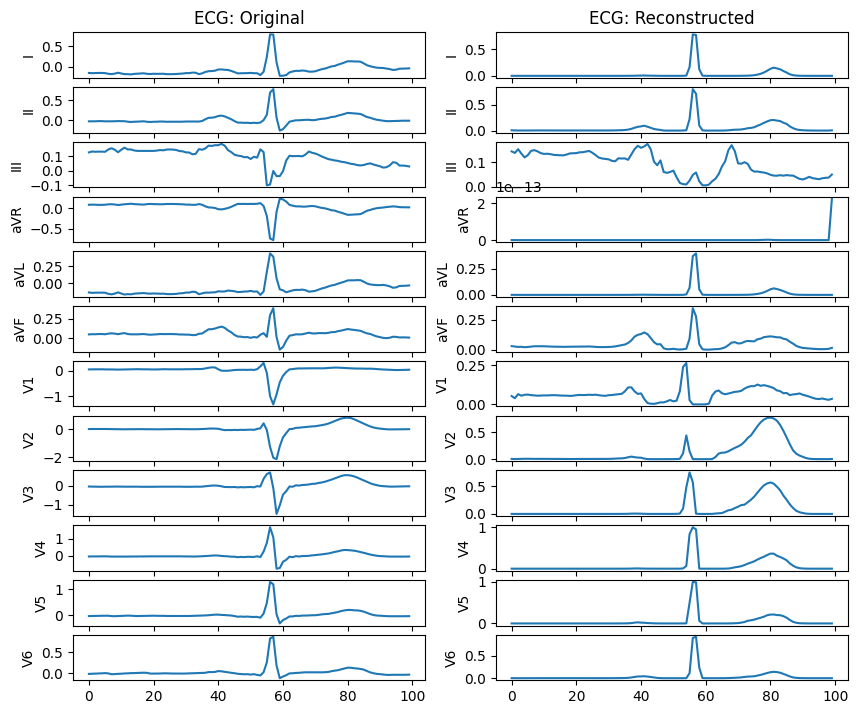

In [37]:
# get a random sample
idx = random.randint(0, X_train.shape[0])
sample = X_train[idx]
# augmented_sample = augment_ecg_signal(sample)
# print(sample.shape, augmented_sample.shape)
# reconstructed_sample = model.predict(augmented_sample[None, ...])[0]
# print(reconstructed_sample.shape)
reconstructed_sample = model.predict(sample[None, ...])[0]

# dv.plot_12_lead_ecgs([sample, augmented_sample, reconstructed_sample], ['Original', 'Augmented', 'Reconstructed'])
dv.plot_12_lead_ecgs([sample, reconstructed_sample], ['Original', 'Reconstructed'])

In [30]:
# cnn autoencoder

def build_cnn_autoencoder(input_shape):
    X = keras.Input(shape=input_shape)
    # Encoder
    # (None, 100, 12)
    x = layers.Conv1D(32, 5, activation='relu', padding='same')(X)
    # (None, 100, 32)
    x = layers.MaxPooling1D(2, padding='same')(x)
    # (None, 50, 32)
    x = layers.Conv1D(64, 3, activation='relu', padding='same')(x)
    # (None, 50, 16)
    x = layers.MaxPooling1D(2, padding='same')(x)
    # (None, 25, 16)
    x = layers.Conv1D(64, 3, activation='relu', padding='same')(x)
    # (None, 25, 8)
    x = layers.MaxPooling1D(2, padding='same')(x)
    # (None, 13, 8)
    # x = layers.Conv1D(8, 3, activation='relu', padding='same')(x)
    # (None, 13, 8)
    encoded = layers.MaxPooling1D(2, padding='same')(x)
    # Decoder
    # x = layers.Conv1D(8, 3, activation='relu', padding='same')(encoded)
    # x = layers.UpSampling1D(2)(x)
    x = layers.Conv1D(64, 3, activation='relu', padding='same')(x)
    x = layers.UpSampling1D(2)(x)
    x = layers.Conv1D(32, 3, activation='relu', padding='same')(x)
    x = layers.UpSampling1D(2)(x)
    x = layers.Conv1D(16, 3, activation='relu')(x)
    x = layers.UpSampling1D(2)(x)
    decoded = layers.Conv1D(12, 3, activation='sigmoid', padding='same')(x)
    return keras.Model(inputs=X, outputs=decoded)

model = build_cnn_autoencoder(X_train.shape[1:])
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 100, 12)]         0         
                                                                 
 conv1d_54 (Conv1D)          (None, 100, 32)           1952      
                                                                 
 max_pooling1d_28 (MaxPoolin  (None, 50, 32)           0         
 g1D)                                                            
                                                                 
 conv1d_55 (Conv1D)          (None, 50, 64)            6208      
                                                                 
 max_pooling1d_29 (MaxPoolin  (None, 25, 64)           0         
 g1D)                                                            
                                                                 
 conv1d_56 (Conv1D)          (None, 25, 64)            1235

In [31]:
train_autoencoder(model, X_train, epochs=5, batch_size=32)

Epoch 1/5
Epoch 1/5, Step 7179/7179, Loss: 0.0228Epoch 2/5
Epoch 2/5, Step 7179/7179, Loss: 0.0256Epoch 3/5
Epoch 3/5, Step 7179/7179, Loss: 0.0228Epoch 4/5
Epoch 4/5, Step 7179/7179, Loss: 0.0323Epoch 5/5
Epoch 5/5, Step 42/7179, Loss: 0.0220

KeyboardInterrupt: 

In [3]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, UpSampling1D, LSTM, Dense, Conv1DTranspose, Reshape

# Input layer
input_ecg = Input(shape=(100, 12))

# Encoder
x = Conv1D(32, 3, activation='relu', padding='same')(input_ecg)
x = MaxPooling1D(2, padding='same')(x)
x = Conv1D(64, 3, activation='relu', padding='same')(x)
x = MaxPooling1D(2, padding='same')(x)
x = LSTM(50, return_sequences=False)(x)

# Bottleneck layer
bottleneck = Dense(50, activation='linear')(x)

# Decoder
x = Dense(25 * 50, activation='relu')(bottleneck)  # Reshape the bottleneck output to 3D
x = Reshape((25, 50))(x)  # Reshape to (timesteps, features) to be compatible with LSTM
x = LSTM(50, return_sequences=True)(x)
x = UpSampling1D(2)(x)
x = Conv1DTranspose(64, 3, activation='relu', padding='same')(x)
x = UpSampling1D(2)(x)
x = Conv1DTranspose(32, 3, activation='relu', padding='same')(x)

# Output layer
output_ecg = Conv1DTranspose(12, 3, activation='linear', padding='same')(x)

# Autoencoder model
autoencoder = Model(input_ecg, output_ecg)
autoencoder.compile(optimizer='adam', loss='mse')

# Summary of the model
autoencoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 100, 12)]         0         
                                                                 
 conv1d_4 (Conv1D)           (None, 100, 32)           1184      
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 50, 32)           0         
 1D)                                                             
                                                                 
 conv1d_5 (Conv1D)           (None, 50, 64)            6208      
                                                                 
 max_pooling1d_5 (MaxPooling  (None, 25, 64)           0         
 1D)                                                             
                                                                 
 lstm_4 (LSTM)               (None, 50)                2300

In [12]:
train_autoencoder(autoencoder, X_train, epochs=10, batch_size=32)


Epoch 1/10


2024-05-28 18:21:58.347956: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8907
2024-05-28 18:21:59.134906: E tensorflow/compiler/xla/stream_executor/dnn.cc:887] <unknown cudnn status: 14>
in tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc(2112): 'cudnnRNNForwardTraining( cudnn.handle(), rnn_desc.handle(), model_dims.max_seq_length, input_desc.handles(), input_data.opaque(), input_h_desc.handle(), input_h_data.opaque(), input_c_desc.handle(), input_c_data.opaque(), rnn_desc.params_handle(), params.opaque(), output_desc.handles(), output_data->opaque(), output_h_desc.handle(), output_h_data->opaque(), output_c_desc.handle(), output_c_data->opaque(), workspace.opaque(), workspace.size(), reserve_space.opaque(), reserve_space.size())'
2024-05-28 18:21:59.134933: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at cudnn_rnn_ops.cc:1564 : INTERNAL: Failed to call ThenRnnForward with model config: [rnn_mode, rnn_input_mode, rnn_

InternalError: Exception encountered when calling layer 'lstm_4' (type LSTM).

{{function_node __wrapped__CudnnRNN_device_/job:localhost/replica:0/task:0/device:GPU:0}} Failed to call ThenRnnForward with model config: [rnn_mode, rnn_input_mode, rnn_direction_mode]: 2, 0, 0 , [num_layers, input_size, num_units, dir_count, max_seq_length, batch_size, cell_num_units]: [1, 64, 50, 1, 25, 32, 50]  [Op:CudnnRNN]

Call arguments received by layer 'lstm_4' (type LSTM):
  • inputs=tf.Tensor(shape=(32, 25, 64), dtype=float32)
  • mask=None
  • training=True
  • initial_state=None